# Hyperparameters tuning (MultiOutput estimators for all eigenfrequencies)

The estimators HistGradientBoosting and LightGBM are the most appropriate to predict the frequency of the longitudinal mode. All eigenfrequencies are required as well for a design point and we face to a regression problem with multi targets. That is the reason why the MultiOutputRegressor will be used. Since the best models are determined for a single frequency, we assume that that is the case for the rest of frequencies. The selection of models was skipped, the LGBM Regressor was chosen directly and the hyperparameters will be tuned with a Bayesian method.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [2]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

The columns of the DataFrame df_params are listed in the text file df_params_cols.txt

In [3]:
lst_param = df_params.columns.to_list()

# Load variables

The explanatory variables are defined again

In [4]:
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]

X = df_params[lst_expl + lst_slot_class]
X.head()

,dim_x,dim_y,dim_z,slot_x_length,slot_x_distance,slot_z_length,slot_z_distance,chamfer_x_dim_y,chamfer_x_dim_z,chamfer_y_dim_x,...,cut_x_depth,cut_z_start,cut_z_end,cut_z_depth,seg_x_out,seg_z_out,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,175.06,121.95,240.31,75.993,43.235,78.219,59.508,15.6380,12.0740,1.8138,...,0.88177,25.293,66.060,1.99450,55.3025,57.7760,0,0,0,1
1,173.45,122.77,238.13,81.168,45.859,78.924,57.208,11.7180,9.9347,9.6338,...,4.85900,26.997,56.481,4.80300,50.2765,58.1210,0,0,0,1
2,175.85,116.71,238.10,77.532,45.260,80.099,49.215,2.4722,9.9912,3.8140,...,1.21780,22.264,51.204,0.81847,51.1600,63.3175,0,0,0,1
3,173.51,116.37,238.30,82.428,51.007,74.757,50.840,12.1080,12.8380,1.8759,...,4.16500,37.379,58.304,1.02820,42.6395,61.3350,0,0,0,1
4,175.60,118.72,241.04,76.576,45.981,78.773,64.702,15.8700,11.0240,9.8682,...,0.64304,27.381,51.502,0.74029,51.5485,55.4490,0,0,0,1


# Definition of the target(s)

The goal is to predict a set of eigenfrequencies, the target is multidimensional and the variables are stored in the matrix Y. The frequencies around the longitudinal mode are the most interesting. By choosing the frequencies of the modes from 50 to 85, we ensure that the longitudinal mode is always in the range of selected frequencies.

In [5]:
# Target variables: selection of all frequencies of modes 50 to 85
lst_freq = lst_param[86:122]
#lst_freq = lst_param[86:91] # Frequencies 50 - 54
Y = df_params[lst_freq]
Y.head()

,freq_50,freq_51,freq_52,freq_53,freq_54,freq_55,freq_56,freq_57,freq_58,freq_59,...,freq_76,freq_77,freq_78,freq_79,freq_80,freq_81,freq_82,freq_83,freq_84,freq_85
0,15590.889,15672.334,15695.955,15724.891,15744.704,16046.922,16098.367,16103.508,16138.404,16179.628,...,19095.403,19217.965,19279.254,19311.640,20316.043,20572.699,20852.411,21007.577,22042.081,22246.846
1,14858.804,15023.859,15027.617,15125.599,15208.897,15222.020,15239.359,15258.175,15299.975,15351.350,...,18435.617,18516.417,18876.657,19386.656,19896.947,19969.016,20487.623,20537.333,21448.323,21657.039
2,14554.333,15084.777,15112.503,15152.934,15175.380,15181.920,15193.222,15224.571,15283.679,15476.935,...,18788.769,19237.203,19256.489,20087.459,20214.271,20731.439,21076.573,21351.086,21746.397,21981.714
3,14242.832,14790.699,15011.165,15118.437,15162.433,15230.318,15241.376,15272.161,15387.168,15425.608,...,19014.610,19168.498,19288.770,19627.057,20209.177,20551.074,20894.240,21101.402,21288.858,21649.534
4,14922.477,15088.412,15369.606,15384.728,15421.654,15548.109,15735.307,15796.236,15868.130,15894.383,...,19012.524,19354.988,19644.580,19813.899,20459.265,20980.660,21029.941,21649.551,21887.022,22085.694


In [6]:
# New Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=55)

## Multi-Output Regressor

We build a pipeline to include the scaling of the input variables and the Multi-Output wrapping the regressor. The optimization of the hyperparameters will be performed on this pipeline. The start estimator LightGBM is set up with some already customized hyperparameters.
In the case of an multi-output prediction, the coefficient of determination R² calculated by weighting all the targets equally if the parameter multioutput = 'uniform_average' is specified.


In [7]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                    )

start_lgbm = LGBMRegressor(n_estimators=400,
                      num_leaves=4,
                      min_child_samples=5,
                      learning_rate=0.1,
                      force_col_wise=True)

pipe_start_lgbm = Pipeline([
                        ('scaler', preprocessor),
                        ('multiregressor', MultiOutputRegressor(start_lgbm))
                        ])
    

In [8]:
# Start model
pipe_start_lgbm.fit(X_train, Y_train)
Y_pred_start_lgbm = pipe_start_lgbm.predict(X_test)

[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 16668.989118
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 16847.349643
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 17015.896527
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 17276.652251
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 17539.445753
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the trai

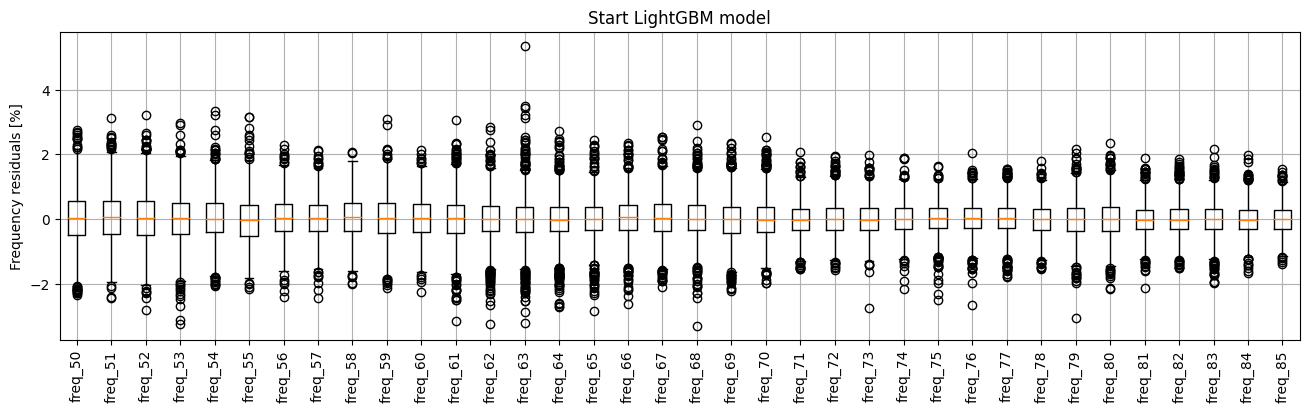

In [9]:
df_freq_residuals = (Y_pred_start_lgbm-Y_test)/Y_test*100

fix, ax = plt.subplots(figsize=(16, 4))
plt.boxplot(df_freq_residuals, labels=lst_freq)
plt.xticks(rotation=90)
plt.grid(True)
plt.title('Start LightGBM model')
plt.ylabel('Frequency residuals [%]')
plt.show()

# Hyperparameters tuning
When the MultiOutputRegressor is wrapping a regressor. the prefix "estimator__" has to be specified to access the underlying LGMB Regressor. BayesSearchCV will apply the same hyperparameters to all regressors in the wrapper.

In [12]:
params_lgbm = {'multiregressor__estimator__n_estimators': Integer(400, 8000),
                'multiregressor__estimator__num_leaves': Integer(4, 12),
                'multiregressor__estimator__min_child_samples': Integer(4, 8),
                'multiregressor__estimator__learning_rate': Real(1e-3, 1e0, prior='log-uniform'),
                'multiregressor__estimator__reg_alpha': Real(1e-5, 1e-2, prior='log-uniform'),
                'multiregressor__estimator__reg_lambda': Real(1e-5, 1e-2, prior='log-uniform')}

bayes_search_lgbm = BayesSearchCV(estimator=pipe_start_lgbm,
                                search_spaces=params_lgbm,
                                n_iter=32,
                                scoring='r2',
                                random_state=55,
                                cv=KFold(n_splits=5, shuffle=True, random_state=55),
                                verbose=True,
                                n_jobs=-1)

In [13]:
# Perform the Bayesian search
bayes_search_lgbm.fit(X_train, Y_train)
print ('Best score:', bayes_search_lgbm.best_score_)
print ('Best parameters:', bayes_search_lgbm.best_params_)
print ('Score of the test set::', bayes_search_lgbm.score(X_test, Y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

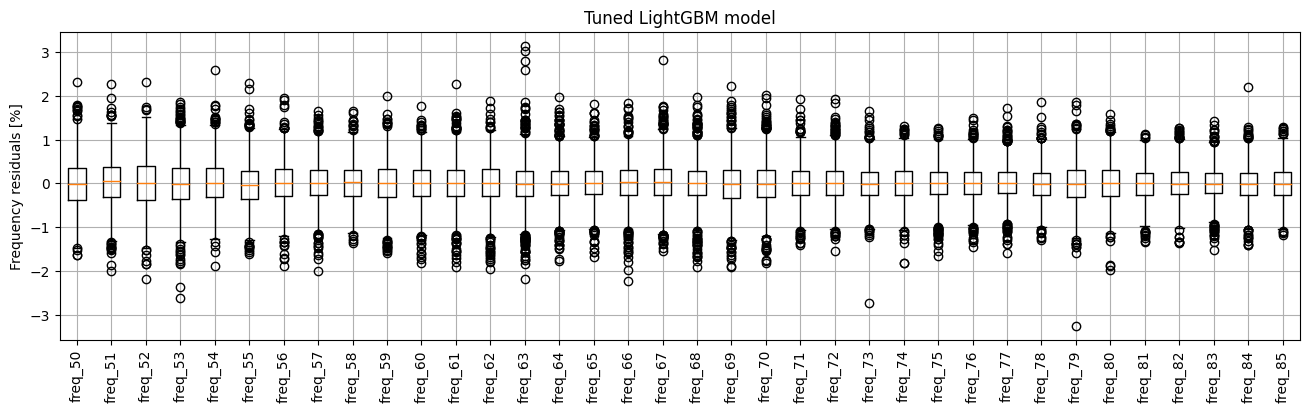

In [14]:
# Prediction
Y_pred_tuned_lgbm = bayes_search_lgbm.predict(X_test)
df_freq_residuals_tuned = (Y_pred_tuned_lgbm-Y_test)/Y_test*100

fix, ax = plt.subplots(figsize=(16, 4))
plt.boxplot(df_freq_residuals_tuned, labels=lst_freq)
plt.xticks(rotation=90)
plt.grid(True)
plt.title('Tuned LightGBM model')
plt.ylabel('Frequency residuals [%]')
plt.show()